In [1]:
%load_ext kedro.extras.extensions.ipython

The kedro.extras.extensions.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.extras.extensions.ipython


In [2]:
%reload_kedro

2022-07-05 18:20:07,704 - kedro.framework.hooks.manager - INFO - Registered hooks from 1 installed plugin(s): kedro-mlflow-0.8.1
2022-07-05 18:20:07,749 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-07-05 18:20:08,264 - root - INFO - ** Kedro project GetInData ML Framework
2022-07-05 18:20:08,265 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-07-05 18:20:08,275 - root - INFO - Registered line magic `run_viz`
2022-07-05 18:20:08,275 - root - INFO - Registered line magic `reload_kedro_mlflow`


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### read catalog

In [5]:
catalog.list()

['articles',
 'customers',
 'transactions',
 'customers_sample',
 'transactions_sample',
 'parameters',
 'params:model_options',
 'params:model_options.test_size',
 'params:model_options.random_state',
 'params:model_options.features',
 'params:model_options_experimental',
 'params:model_options_experimental.test_size',
 'params:model_options_experimental.random_state',
 'params:model_options_experimental.features',
 'params:cutoff_date',
 'params:sample_size']

In [6]:
df = context.catalog.load('transactions')

2022-07-05 18:20:20,020 - kedro.io.data_catalog - INFO - Loading data from `transactions` (CSVDataSet)...


df_articles = context.catalog.load('articles')

In [7]:
df_customers = context.catalog.load('customers')

2022-07-05 18:20:39,517 - kedro.io.data_catalog - INFO - Loading data from `customers` (CSVDataSet)...


### transactions

In [8]:
df.shape

(31788324, 5)

In [9]:
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.0508,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.0305,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.0152,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.0169,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.0169,2


In [10]:
df.dtypes

t_dat                object
customer_id          object
article_id           object
price               float64
sales_channel_id      int64
dtype: object

In [11]:
df.t_dat = pd.to_datetime(df.t_dat)

In [12]:
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                  object
price                      float64
sales_channel_id             int64
dtype: object

### Sample step 1: only latest transactions

In [13]:
df.t_dat.describe(datetime_is_numeric=True)

count                         31788324
mean     2019-09-15 17:27:46.894452992
min                2018-09-20 00:00:00
25%                2019-03-28 00:00:00
50%                2019-08-25 00:00:00
75%                2020-03-29 00:00:00
max                2020-09-22 00:00:00
Name: t_dat, dtype: object

In [14]:
df[df.t_dat>'2020-04-01'].t_dat.describe(datetime_is_numeric=True)

count                          7814649
mean     2020-06-24 11:18:54.437897728
min                2020-04-02 00:00:00
25%                2020-05-19 00:00:00
50%                2020-06-23 00:00:00
75%                2020-08-03 00:00:00
max                2020-09-22 00:00:00
Name: t_dat, dtype: object

In [15]:
df = df[df.t_dat>'2020-04-01'].reset_index(drop=True)

In [16]:
df.shape

(7814649, 5)

### Sample step 2: stratified sampling

In [17]:
df_customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0000,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0000,1.0000,ACTIVE,Regularly,52.0000,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.0000,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.0000,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0000,1.0000,ACTIVE,Regularly,21.0000,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0000,1.0000,ACTIVE,Regularly,18.0000,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


In [18]:
cd_customers_trans = df.groupby(['customer_id'])['t_dat'].nunique().reset_index(name='no_transactions')

In [20]:
cd_customers_trans.columns

Index(['customer_id', 'no_transactions'], dtype='object')

In [21]:
df_customers = df_customers.merge(cd_customers_trans, on='customer_id', how='left')

In [23]:
df_customers.columns

Index(['customer_id', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'no_transactions'],
      dtype='object')

### fillna() for sampling

In [20]:
df_customers.isna().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
no_transactions           641191
dtype: int64

In [21]:
df_customers['age'] = df_customers['age'].fillna(df_customers['age'].median())

In [22]:
df_customers['no_transactions'] = df_customers['no_transactions'].fillna(0)

In [23]:
df_customers[['age', 'no_transactions']].describe()

,age,no_transactions
count,1371980.0000,1371980.0000
mean,36.3362,1.5882
std,14.2384,2.7852
min,16.0000,0.0000
25%,24.0000,0.0000
50%,32.0000,1.0000
75%,49.0000,2.0000
max,99.0000,127.0000


In [24]:
df_customers['age_bin'] = pd.qcut(df_customers['age'], 4, labels=['1', '2', '3', '4']).astype(str)

<AxesSubplot:>

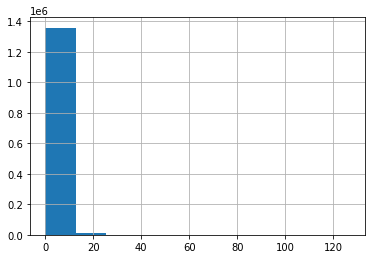

In [25]:
df_customers.no_transactions.hist()

#### i'm doing custom bins for no_transactions, because the distribution is heavily concentrated around 0

In [26]:
cond_list = [
    df_customers['no_transactions']==0,
    df_customers['no_transactions']<=1,
    df_customers['no_transactions']<=3,
    df_customers['no_transactions']<=6,
    df_customers['no_transactions']<=9
]

In [27]:
choice_list = [
    '1',
    '2',
    '3',
    '4',
    '5'
]

In [28]:
np.unique(np.select(cond_list, choice_list, default='6'), return_counts=True)

(array(['1', '2', '3', '4', '5', '6'], dtype='<U1'),
 array([641191, 299884, 238523, 123263,  40266,  28853]))

In [29]:
df_customers['no_transactions_bin'] = np.select(cond_list, choice_list, default='6')

In [30]:
df_customers.shape

(1371980, 10)

In [31]:
_, df_customers_sample = train_test_split(df_customers, test_size=0.1,
                                          stratify=df_customers[['age_bin', 'no_transactions_bin']])

In [32]:
df_customers_sample.shape

(137198, 10)

### check

In [33]:
df_customers[['age_bin']].value_counts(normalize=True)

age_bin
2         0.2643
1         0.2603
3         0.2436
4         0.2318
dtype: float64

In [34]:
df_customers[['no_transactions_bin']].value_counts(normalize=True)

no_transactions_bin
1                     0.4673
2                     0.2186
3                     0.1739
4                     0.0898
5                     0.0293
6                     0.0210
dtype: float64

In [35]:
df_customers_sample[['age_bin']].value_counts(normalize=True)

age_bin
2         0.2643
1         0.2603
3         0.2436
4         0.2318
dtype: float64

In [36]:
df_customers_sample[['no_transactions_bin']].value_counts(normalize=True)

no_transactions_bin
1                     0.4673
2                     0.2186
3                     0.1739
4                     0.0898
5                     0.0293
6                     0.0210
dtype: float64

### filter out other datasets

In [37]:
df_customers_sample.drop(['no_transactions', 'age_bin', 'no_transactions_bin'], axis=1, inplace=True)

In [38]:
df_customers_sample

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
141330,1a56e15ce7e11435919d6458012c68c36d0f752cb135a5...,NaN,NaN,ACTIVE,NONE,24.0000,2c29ae653a9282cce4151bd87643c907644e09541abc28...
1316855,f5b7c8940861818b38c8594c34d188d049204355715f7a...,NaN,NaN,ACTIVE,NONE,27.0000,bba5c13707adb11cc47e7a69ec6a8224bf75bcdf28991e...
774907,90ac6a41287d94361e2219e744885dd73705cddc95030e...,1.0000,1.0000,ACTIVE,Regularly,45.0000,2c29ae653a9282cce4151bd87643c907644e09541abc28...
1271123,ed34f711927c10d08922db0ef98067c980951557295cf2...,NaN,NaN,ACTIVE,NONE,48.0000,806c3236457061e2b5908e2a4b1c2c4dc8da339dcbcae3...
1157300,d7e94ea6ea38f4a3511a8a16abddb59c498f811b94468e...,NaN,NaN,ACTIVE,NONE,21.0000,b27605b7d5066e545608294db968e3794857d75ac79e1f...
...,...,...,...,...,...,...,...
551814,670189c52a0fd0608f8684a504740d695656a422447b0c...,1.0000,1.0000,ACTIVE,Regularly,65.0000,ea0f4adbd74116efcc746391f0bd687f9fc7fb6472fc65...
227851,2a846b86f2647e5ec4623e455a7d121d6e74e3dafdecc8...,NaN,NaN,PRE-CREATE,NONE,58.0000,77a1020f1f5c0985dc095e2a11201687b419834b0748e2...
784209,92675bcbb3f2d9d76a1f81d2984c3c27cb89679ac05f1e...,NaN,NaN,ACTIVE,NONE,19.0000,d05e587b5099edd2ecdb93bc72c2789dd6ee1d248517bf...
1078507,c94381600efb852db4764355d814d20ec48f09b46c7afc...,1.0000,1.0000,ACTIVE,Regularly,55.0000,5495fd921e34daf5e271bca153a638f091c19b50245547...


In [39]:
unique_customer_id_set = set(df_customers_sample.customer_id.unique())

In [40]:
df_sample = df[df.customer_id.isin(unique_customer_id_set)]

In [42]:
### i don't whether to sample ARTICLES -> if filtered off then no cold-start problem.
### On the other hand, you NEED TO SAMPLE for EMBEDDINGS, maybe another pipeline for that?

In [41]:
df_sample.shape, df_customers_sample.shape

((778995, 5), (137198, 7))